## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
sns.set()

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mice_data = pd.merge(mouse_metadata, study_results, how='left', on='Mouse ID')
mice_data.set_index('Mouse ID', inplace=True)
pd.options.display.float_format = '{:,.2f}'.format

# Display the data table for preview
mice_data.head()

,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,,,,,,,
k403,Ramicane,Male,21,16,0,45.00,0
k403,Ramicane,Male,21,16,5,38.83,0
k403,Ramicane,Male,21,16,10,35.01,1
k403,Ramicane,Male,21,16,15,34.22,1
k403,Ramicane,Male,21,16,20,33.00,1


In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [3]:
mice_data.shape

(1893, 7)

In [4]:
# Checking missing values
mice_data.isnull().sum()

Drug Regimen          0
Sex                   0
Age_months            0
Weight (g)            0
Timepoint             0
Tumor Volume (mm3)    0
Metastatic Sites      0
dtype: int64

In [5]:
# Checking the types of data
mice_data.dtypes

Drug Regimen           object
Sex                    object
Age_months              int64
Weight (g)              int64
Timepoint               int64
Tumor Volume (mm3)    float64
Metastatic Sites        int64
dtype: object

In [6]:
# Checking the number of mice.
mice_data.index.value_counts(normalize=True)

g989   0.01
f345   0.01
i177   0.01
e227   0.01
l897   0.01
       ... 
h428   0.00
l872   0.00
n482   0.00
x226   0.00
o848   0.00
Name: Mouse ID, Length: 249, dtype: float64

In [7]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
mice_data.groupby(mice_data.index)['Timepoint'].describe()

,count,mean,std,min,25%,50%,75%,max
Mouse ID,,,,,,,,
a203,10.00,22.50,15.14,0.00,11.25,22.50,33.75,45.00
a251,10.00,22.50,15.14,0.00,11.25,22.50,33.75,45.00
a262,10.00,22.50,15.14,0.00,11.25,22.50,33.75,45.00
a275,10.00,22.50,15.14,0.00,11.25,22.50,33.75,45.00
a366,7.00,15.00,10.80,0.00,7.50,15.00,22.50,30.00
...,...,...,...,...,...,...,...,...
z435,3.00,5.00,5.00,0.00,2.50,5.00,7.50,10.00
z578,10.00,22.50,15.14,0.00,11.25,22.50,33.75,45.00
z581,10.00,22.50,15.14,0.00,11.25,22.50,33.75,45.00


In [8]:
# Optional: Get all the data for the duplicate mouse ID. 
duplicates = mice_data.duplicated()
duplicates.value_counts(normalize=True)

False   1.00
True    0.00
dtype: float64

In [9]:
mice_data[duplicates].sort_values('Drug Regimen')

,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,,,,,,,
f345,Infubinol,Male,23,26,0,45.00,0
k804,Infubinol,Female,23,29,0,45.00,0
s121,Infubinol,Male,23,26,0,45.00,0
r850,Placebo,Male,5,30,0,45.00,0
v409,Placebo,Female,16,25,0,45.00,0
g989,Propriva,Female,21,26,0,45.00,0
z578,Ramicane,Male,11,16,0,45.00,0
d133,Zoniferol,Male,5,30,0,45.00,0


In [10]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mice_data.drop_duplicates(inplace = True)

In [11]:
# Checking the number of mice in the clean DataFrame.
mice_data.shape

(1885, 7)

## Summary Statistics

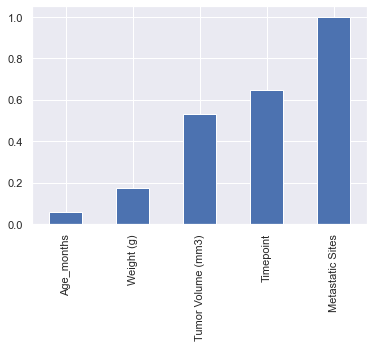

In [32]:
#Exploratory Analysis
# Correlation dendrogram
# Corr matrix 
_=mice_data.corr()['Metastatic Sites'].sort_values().plot.bar()

In [12]:
# Generate a summary statistics table of the tumor volume for each regimen
mice_data.groupby('Drug Regimen')['Tumor Volume (mm3)'].agg(['mean', 'median','var','std','sem'])

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,53.02,51.85,42.78,6.54,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.13,52.34,60.93,7.81,0.58
Propriva,52.37,50.91,42.28,6.50,0.51
Ramicane,40.20,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


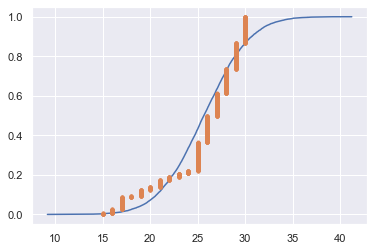

In [27]:
# Determine if the mouse weight is considered normally distributed
mu = np.mean(mice_data['Weight (g)'])
sigma = np.std(mice_data['Weight (g)'])
samples = np.random.normal(mu, sigma, 10000)
x, y = ecdf(mice_data['Weight (g)'])
x_theor, y_theor = ecdf(samples)
_=plt.plot(x_theor, y_theor)
_=plt.plot(x, y, marker='.', linestyle='none')

## Bar and Pie Charts

In [14]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas. 
mice_per_treatment = mice_data.groupby('Drug Regimen').size()
mice_per_treatment

Drug Regimen
Capomulin    230
Ceftamin     178
Infubinol    175
Ketapril     188
Naftisol     186
Placebo      179
Propriva     160
Ramicane     227
Stelasyn     181
Zoniferol    181
dtype: int64

Text(0.5, 1.0, 'Number of mice per treatment')

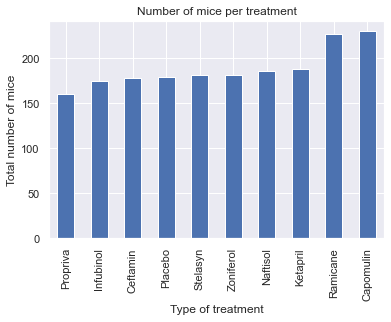

In [15]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.
mice_per_treatment.sort_values().plot(kind='bar')
plt.xlabel('Type of treatment')
plt.ylabel('Total number of mice')
plt.title('Number of mice per treatment')


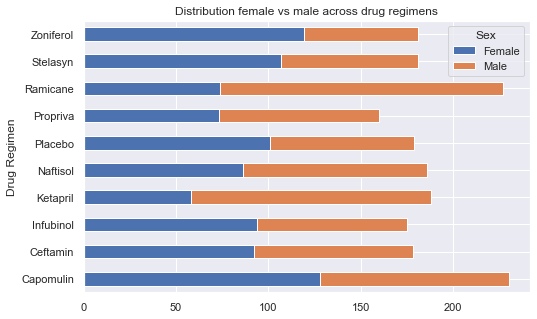

In [16]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
mice_by_sex = mice_data.groupby(['Drug Regimen', 'Sex']).size()
mice_by_sex.unstack().plot(kind='barh', stacked=True, figsize=(8,5), title="Distribution female vs male across drug regimens")

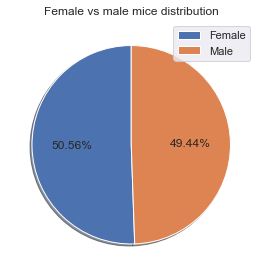

In [17]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(mice_data['Sex'].value_counts(), autopct='%1.2f%%', shadow=True, startangle=90)
plt.title("Female vs male mice distribution")
plt.tight_layout()
plt.legend(['Female', 'Male'],loc="best")

## Quartiles, Outliers and Boxplots

In [18]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
boxplot_df = mice_data.groupby(['Drug Regimen', mice_data.index])[['Timepoint', 'Tumor Volume (mm3)']].agg(
                                                lambda x: [x[i] for i in range(len(x)) if i == len(x)-1][0])

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
boxplot_df

Timepoint  Tumor Volume (mm3)
Drug Regimen Mouse ID                               
Capomulin    b128             45               38.98
             b742             45               38.94
             f966             20               30.49
             g288             45               37.07
             g316             45               40.16
...                          ...                 ...
Zoniferol    q633             45               70.83
             s337             45               62.11
             w140              5               47.72
             w575             45               68.40
             x613             15               48.08

[248 rows x 2 columns]

In [19]:
boxplot_df.index.get_level_values('Drug Regimen')

Index(['Capomulin', 'Capomulin', 'Capomulin', 'Capomulin', 'Capomulin',
       'Capomulin', 'Capomulin', 'Capomulin', 'Capomulin', 'Capomulin',
       ...
       'Zoniferol', 'Zoniferol', 'Zoniferol', 'Zoniferol', 'Zoniferol',
       'Zoniferol', 'Zoniferol', 'Zoniferol', 'Zoniferol', 'Zoniferol'],
      dtype='object', name='Drug Regimen', length=248)

In [20]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [21]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
# x = boxplot_df['Timepoint']
# y = boxplot_df['Tumor Volume (mm3)']
# plt.boxplot(x, y, data=boxplot_df)
# plt.yscale('log')

## Line and Scatter Plots

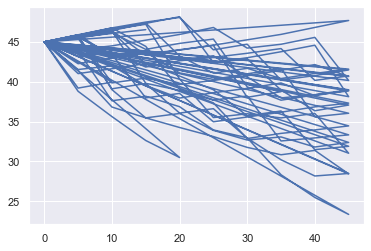

In [22]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
capomulin_df = mice_data[mice_data['Drug Regimen']=='Capomulin']
x = capomulin_df['Timepoint']
y = capomulin_df['Tumor Volume (mm3)']
plt.plot(x,y)

Text(0.5, 1.0, 'Capomulin regimen: mouse weight vs tumor volume')

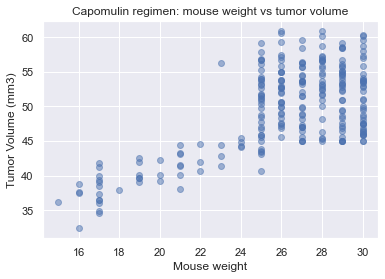

In [23]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
scatter_data = mice_data.groupby(mice_data.index)[['Weight (g)', 'Tumor Volume (mm3)']].mean()
x = scatter_data['Weight (g)']
y = scatter_data['Tumor Volume (mm3)']
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Mouse weight')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Capomulin regimen: mouse weight vs tumor volume')

Text(0.5, 1.0, 'Capomulin regimen: mouse weight vs tumor volume')

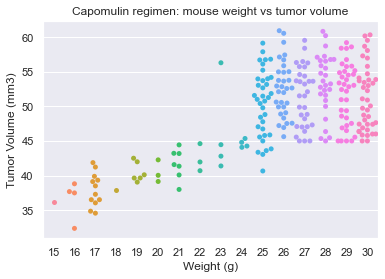

In [24]:
sns.swarmplot(x, y, data=scatter_data)
plt.title('Capomulin regimen: mouse weight vs tumor volume')

## Correlation and Regression

In [25]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
